## **ENTITY VALUE EXTRACTION**

### 0. SETTING UP

In [51]:
import os
import cv2
import matplotlib.pyplot
import re
from PIL import Image
import matplotlib.pyplot as plt
from paddleocr import PaddleOCR, draw_ocr
from constants import unit_variations, entity_unit_map

In [52]:
# DATABASE LOCATION
dataset_path = "data/"

train_path = dataset_path + "train.csv"
test_path = dataset_path + "test.csv"
sample_test_path = dataset_path + "sample_test.csv"

In [53]:
# test if paths exist
import os

for path in [train_path, test_path, sample_test_path]:
    if not os.path.exists(path):
        print(f"Missing CSV File: {path}")

### 1. HELPER FUNCTIONS

In [54]:
def display_image(image):
    plt.figure(figsize = (10, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [55]:
def find_all_indices(s, substring):
    pattern = re.compile(re.escape(substring))
    matches = pattern.finditer(s)
    return [match.start() for match in matches]

In [56]:
from IPython.display import HTML, display

In [57]:
def make_clickable_path(path):
    if os.path.exists(path):
        return f'<a href="{path}" target="_blank">{path}</a>'
    else:
        return f'Path does not exist: {path}'

def display_path(path):
    display(HTML(make_clickable_path(path)))

### 2. TRAINING

In [58]:
import re
from PIL import Image
import matplotlib.pyplot as plt

from paddleocr import PaddleOCR, draw_ocr

from constants import unit_variations, entity_unit_map

In [59]:
image_path = r"D:/Programming/Rainforest/Code/data/train_images/31aalwb8cdL.jpg"
image_entity = "item_weight"
font_path = r"D:/Programming/Rainforest/Code/PaddleOCR/doc/fonts/latin.ttf"

#### (i) PREPROCESSING

In [60]:
image = cv2.imread(image_path)

In [61]:
print(image)

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [62]:
def preprocess_image(image_in):
    image_out = cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB)
    # image_out = cv2.cvtColor(image_in, cv2.COLOR_BGR2GRAY)
    """
    pre process some tings
    """

    return image_out

In [63]:
image = preprocess_image(image)

Preprocessed Image


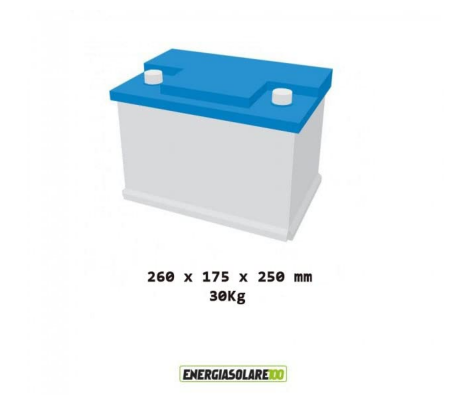

In [64]:
print("Preprocessed Image")
display_image(image)

#### (ii) TEXT RECOGNITION

In [65]:
ocr = PaddleOCR(use_angle_cls=True, lang='en')

[2024/09/15 13:17:57] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=False, use_xpu=False, use_npu=False, use_mlu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='C:\\Users\\shash/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='C:\\Users\\shash/.paddleocr/whl\\rec\\en\\en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=

In [66]:
def get_ocr(image_array, cls_in):
    return ocr.ocr(image_array, cls = cls_in)

In [67]:
def show_ocr(image_in, result):
    boxes = [item[0] for item in result[0]]
    texts = [item[1][0] for item in result[0]]
    scores = [item[1][1] for item in result[0]]

    im_show = draw_ocr(image_in, boxes, texts, scores, font_path=font_path)
    display_image(im_show)

In [68]:
result = ocr.ocr(image)

[2024/09/15 13:17:59] ppocr DEBUG: dt_boxes num : 3, elapsed : 0.38740086555480957
[2024/09/15 13:17:59] ppocr DEBUG: cls num  : 3, elapsed : 0.06878876686096191
[2024/09/15 13:17:59] ppocr DEBUG: rec_res num  : 3, elapsed : 0.1773667335510254


OCR Output:


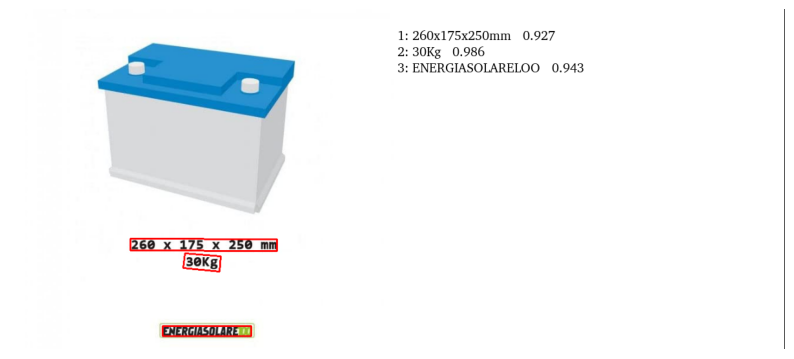

In [69]:
print("OCR Output:")
show_ocr(image, result)

#### (iii) POST PROCESSING

In [70]:
def extract(result_in, entity_name):
    extracted_measurements = []
    extracted_positions = []
    for r in result_in[0]:
        location, line = r
        text = line[0]

        for unit in entity_unit_map[entity_name]:
            for rep in unit_variations[unit]:
                indices = find_all_indices(text.lower(), rep.lower())

                for index in indices:
                    if index <= 0:
                        continue

                    numbers = [""]
                    reformat = text[:index].replace(' ', '')

                    i = len(reformat) - 1

                    while (i >= 0) and (reformat[i].isnumeric() or reformat[i] in ['-', '.', 'I']):
                        char = reformat[i]
                        
                        if i==0 and char == "I":
                            char = '1'

                        if char.isnumeric():
                            numbers[-1] = char + numbers[-1]
                        elif char in ['.', ',']:
                            numbers[-1] = '.' + numbers[-1]
                        elif char in ['-']:
                            numbers.append("")

                        i -= 1

                    discard_rule = lambda x: len(x.strip().replace('.', '')) > 0
                    # print(numbers)
                    numbers = filter(discard_rule, numbers)
                    numbers = sorted(list(map(lambda x: float(x), numbers)))

                    if len(numbers) == 0:
                        continue
                    else:
                        leftmostPoint = float('inf')
                        rightmostPoint = 0
                        bottommostPoint=float('inf')
                        topmostpoint = 0

                        for point in location:
                            leftmostPoint = min(leftmostPoint,point[0])
                            rightmostPoint = max(rightmostPoint,point[0])
                            bottommostPoint = min(bottommostPoint,point[1])
                            topmostpoint = max(topmostpoint,point[1])

                    measurement = f"[{numbers[0]}, {numbers[1]}] {unit}" if len(numbers) > 1 else f"{numbers[0]} {unit}"
                    extracted_measurements.append(measurement)
                    extracted_positions.append([measurement,leftmostPoint,rightmostPoint,bottommostPoint,topmostpoint])

    return extracted_measurements,extracted_positions

In [71]:
extract(result, image_entity)

(['30.0 kilogram'], [['30.0 kilogram', 295.0, 359.0, 416.0, 447.0]])

### 3. VALIDATION

In [72]:
import pandas as pd

In [73]:
from IPython.display import clear_output

In [74]:
image_folder = "data/train_images/"
validation_path = "data/downloaded_train.csv"

In [75]:
validation = pd.read_csv(validation_path)

In [76]:
def debug_output(original_image, ocr_result, image_path, e_name, e_value, p_list, p_value):
    display_path(image_path)
    show_ocr(original_image, ocr_result)
    print("entity name:", e_name)
    print("expected value:", e_value)
    print("predicted list:", p_list)
    print("prediction value:", p_value)

[2024/09/15 13:44:06] ppocr DEBUG: dt_boxes num : 17, elapsed : 0.09690570831298828
[2024/09/15 13:44:06] ppocr DEBUG: cls num  : 17, elapsed : 0.08316826820373535
[2024/09/15 13:44:06] ppocr DEBUG: rec_res num  : 17, elapsed : 0.2659447193145752
['6.0 foot', 922.0, 977.0, 445.0, 476.0] 1100 499.0
['1200.0 metre', 21.0, 55.0, 615.0, 751.0] 1100 499.0
['1200.0 millimetre', 21.0, 55.0, 615.0, 751.0] 1100 499.0
['510.0 metre', 704.0, 822.0, 919.0, 950.0] 1100 499.0
['510.0 millimetre', 704.0, 822.0, 919.0, 950.0] 1100 499.0
['1150.0 metre', 357.0, 490.0, 1021.0, 1053.0] 1100 499.0
['1150.0 millimetre', 357.0, 490.0, 1021.0, 1053.0] 1100 499.0
['1200.0 metre', '1200.0 millimetre', '6.0 foot', '510.0 metre', '510.0 millimetre', '1150.0 metre', '1150.0 millimetre']
1200.0 millimetre
1200.0 millimetre
6/999


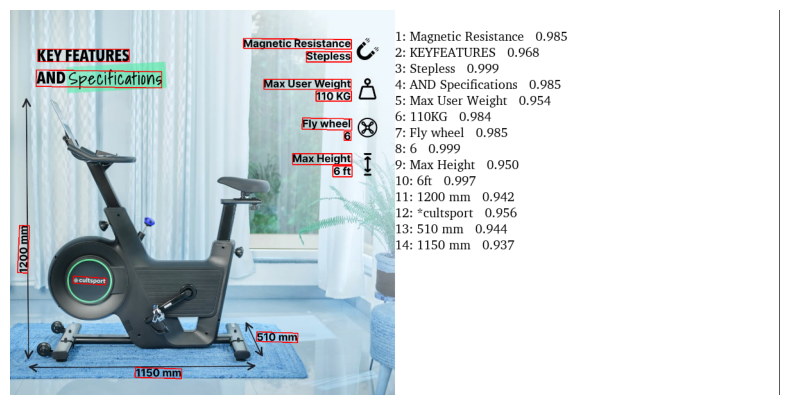

entity name: 95.0 centimetre
expected value: height
predicted list: ['1200.0 millimetre', '1200.0 metre', '6.0 foot', '510.0 metre', '510.0 millimetre', '1150.0 metre', '1150.0 millimetre']
prediction value: 1200.0 millimetre


In [84]:
def run_on_row(validation, row_index):
    row = validation.iloc[row_index]

    if not row["downloaded"]:
        return

    image_name = os.path.basename(row["image_link"])
    image_path = './61Byi7hvtFL.jpg'

    entity_name = 'height'
    entity_value = row["entity_value"]

    original_image = cv2.imread(image_path)
    image_array = preprocess_image(original_image)
    ocr_result = get_ocr(image_array, cls_in = True)

    try:
        predictions,positions = extract(ocr_result, entity_name)
        if entity_name == 'height' or entity_name == 'width' :
            globalLeftmost = float('inf')
            globalRightmost = 0
            globalBottommost = float('inf')
            globalTopmost = 0
            dist_from_wall = []
            dist_from_middle =[]
            
            height,width,_=image_array.shape

            for position in positions:
                globalLeftmost = min(globalLeftmost,position[1])
                globalRightmost = max(globalRightmost,position[2])
                globalBottommost = min(globalBottommost,position[3])
                globalTopmost = max(globalTopmost,position[4])
                
                dist_from_wall.append([position[0],min(abs(0 - (position[1] + position[2])/2),width - (position[1] + position[2])/2)])
                
            middle = (globalLeftmost + globalRightmost)/2

            for position in positions:
                print(position,width,middle)
                dist_from_middle.append([position[0],abs(middle - (position[1] + position[2])/2 )])
                
            if entity_name == 'height':
                predictions = list(map(lambda x: x[0], sorted(dist_from_wall, key = lambda x: x[1])))
                num_0, unit_0 = predictions[0].split(' ')
                num_1, unit_1 = predictions[1].split(' ')
                print(predictions)
                if num_1 > num_0 :
                    predictions[0] = predictions[1]
            else:
                if len(predictions) == 2:
                    predictions = list(map(lambda x: x[0], sorted(dist_from_wall, key = lambda x: -x[1])))
                else:
                    predictions = list(map(lambda x: x[0], sorted(dist_from_middle, key = lambda x: x[1])))
                    
        if len(predictions) > 1:
            num_0, unit_0 = predictions[0].split(' ')
            num_1, unit_1 = predictions[1].split(' ')

            if num_0 == num_1 and len(unit_1) > len(unit_0):
                predictions[0], predictions[1] = predictions[1], predictions[0]

        pred_value = list(predictions)[0] if len(predictions) > 0 else ""
        print(pred_value)
                    

    
        pred_value = list(predictions)[0] if len(predictions) > 0 else ""
        print(pred_value)
    except Exception as e:
        predictions,positions = extract(ocr_result, entity_name)
        if entity_name == 'height' or entity_name == 'width' :
            globalLeftmost = float('inf')
            globalRightmost = 0
            globalBottommost = float('inf')
            globalTopmost = 0
            dist_from_wall = []
            dist_from_middle =[]
            
            height,width,_=image_array.shape

            for position in positions:
                globalLeftmost = min(globalLeftmost,position[1])
                globalRightmost = max(globalRightmost,position[2])
                globalBottommost = min(globalBottommost,position[3])
                globalTopmost = max(globalTopmost,position[4])
                
                dist_from_wall.append([position[0],min(abs(0 - (position[1] + position[2])/2),width - (position[1] + position[2])/2)])
                
            middle = (globalLeftmost + globalRightmost)/2

            for position in positions:
                print(position,width,middle)
                dist_from_middle.append([position[0],abs(middle - (position[1] + position[2])/2 )])
                
            if entity_name == 'height':
                predictions = list(map(lambda x: x[0], sorted(dist_from_wall, key = lambda x: x[1])))
                num_0, unit_0 = predictions[0].split(' ')
                num_1, unit_1 = predictions[1].split(' ')

                if num_1 > num_0 :
                    predictions[0] = predictions[1]
            else:
                if len(predictions) == 2:
                    predictions = list(map(lambda x: x[0], sorted(dist_from_wall, key = lambda x: -x[1])))
                else:
                    predictions = list(map(lambda x: x[0], sorted(dist_from_middle, key = lambda x: x[1])))
                    
        if len(predictions) > 1:
            num_0, unit_0 = predictions[0].split(' ')
            num_1, unit_1 = predictions[1].split(' ')

            if num_0 == num_1 and len(unit_1) > len(unit_0):
                predictions[0], predictions[1] = predictions[1], predictions[0]

        pred_value = list(predictions)[0] if len(predictions) > 0 else ""
        print(pred_value)
    if True or pred_value.strip() != entity_value.strip():
        print(f"{index + 1}/{len(validation) - 1}")
        debug_output(original_image, ocr_result, image_path, entity_value, entity_name, predictions, pred_value)

        choice = input("continue [y]: ")
        if len(choice.strip()) > 0:
            return


    clear_output(wait = True)
run_on_row(validation,536)